# Notebook summary

This notebook analyzes how the margin of error impacts OBC designation on the basis of the 

# Notes and abbreviations

ABBREVIATIONS 

BG = block group

pop = population

VRE = variance replicate estimates

MOE = margin of error

CI = confidence interval

DATA REFERENCE NOTES

When column ORDER = 1, estimate is for total population (expressed as # of individuals)

When column ORDER = 8, estimate is for pop whose income is 2.0 times the poverty line (expressed as # of individuals)

CONFIDENCE INTERVALS

Produce estimate of pop whose income is 2.0 times the poverty line (expressed as a PERCENT of the total pop)  

Produce margin of error of estimate (expressed as a PERCENT)

(e.g. BG is 50% low income +/- 15% low income)

# Create directory for project

- RATIONALE: Must create a file directory for input and output files used in the script
- LOGIC: Creates a new file directory according to specified path with data directory called "data" (same path for ipath and opath)
- INPUT: Replace the path to the new directory
- OUTPUT: File directory according to specified path

In [ ]:
import os
import pandas as pd
import csv

# Define the path for the new directory
new_directory = "path/to/new_directory"

# Create the directory
try:
    os.makedirs(new_directory, exist_ok=True)
    print(f"Directory '{new_directory}' created successfully")
except Exception as e:
    print(f"Error creating directory '{new_directory}': {e}")

# Define the path for the data directory
data_directory = os.path.join(new_directory, 'data')

# Create the data directory
try:
    os.makedirs(data_directory, exist_ok=True)
    print(f"Directory '{data_directory}' created successfully")
except Exception as e:
    print(f"Error creating directory '{data_directory}': {e}")

# Define input and output file paths (same path)
ipath = data_directory
opath = data_directory



In [2]:
import pandas as pd
import os
import csv

# Define input and output file paths
path = os.path.join(os.path.dirname(os.getcwd()))
ipath = os.path.join(path,'data')
opath = os.path.join(path,'data')
input_file_dir=os.path.join(ipath)
output_file_dir=os.path.join(opath)


# Download VRE table and prepare file

- RATIONALE: Will use variance replicates table to calculate percent low income margin of error for each BG
- LOGIC: Rewrites new VRE file containing only relevant rows and columns for analysis 
- INPUT: Go to https://www2.census.gov/programs-surveys/acs/replicate_estimates/2022/data/5-year/150/
and download C17002_34.csv.zip, then add to data directory and unzip
- OUTPUT: New csv called 'edited_VRE_complete_NJ.csv'

NOTE: 

Rows retained are those in which ORDER = 1 correspond to the total population estimates, and ORDER = 8 correspond to estimates for number of people whose income is 2.0 times the poverty line

Columns retained are GEOID, ORDER ESTIMATE, and all 80 VAR_REPs

In [3]:
#Edit VRE file so it contains only rows and columns relevant to this project's MOE analysis
import os
import csv

# Define input and output file paths
input_file_name = 'C17002_34.csv'
input_file = f"{ipath}/{input_file_name}"
output_file_name = 'edited_VRE_complete_NJ.csv'
output_file = f"{opath}/{output_file_name}"
output_csvfile = open(output_file, 'w')

# Open the output file for writing
with open(output_file, 'w', newline='') as output_csvfile:
    writer = csv.writer(output_csvfile)

    # Open the input file for reading
    with open(input_file, 'r') as csvfile:
        reader = csv.reader(csvfile)
        
        # Process each row in the input file
        for idx, row in enumerate(reader):
            if idx == 0:
                # Create and write new header
                new_header = [row[1], row[3], row[5]]
                new_header.extend(row[9:])
                writer.writerow(new_header)
                # Print the header
                print(new_header)
            elif idx >= 3:
                try:
                    # Convert the order column to an integer
                    order_row = int(row[3])
                except ValueError:
                    continue

                # Skip rows based on the order column value
                if order_row > 1 and order_row < 8:
                    continue

                # Create a new row with selected columns
                new_row = [row[1], row[3], row[5]]
                new_row.extend(row[9:])
                writer.writerow(new_row)
                
                # Print the first two rows
                if idx < 5:
                    print(new_row)

print(f"Output file saved as {output_file}")


['GEOID', 'ORDER', 'ESTIMATE', 'Var_Rep1', 'Var_Rep2', 'Var_Rep3', 'Var_Rep4', 'Var_Rep5', 'Var_Rep6', 'Var_Rep7', 'Var_Rep8', 'Var_Rep9', 'Var_Rep10', 'Var_Rep11', 'Var_Rep12', 'Var_Rep13', 'Var_Rep14', 'Var_Rep15', 'Var_Rep16', 'Var_Rep17', 'Var_Rep18', 'Var_Rep19', 'Var_Rep20', 'Var_Rep21', 'Var_Rep22', 'Var_Rep23', 'Var_Rep24', 'Var_Rep25', 'Var_Rep26', 'Var_Rep27', 'Var_Rep28', 'Var_Rep29', 'Var_Rep30', 'Var_Rep31', 'Var_Rep32', 'Var_Rep33', 'Var_Rep34', 'Var_Rep35', 'Var_Rep36', 'Var_Rep37', 'Var_Rep38', 'Var_Rep39', 'Var_Rep40', 'Var_Rep41', 'Var_Rep42', 'Var_Rep43', 'Var_Rep44', 'Var_Rep45', 'Var_Rep46', 'Var_Rep47', 'Var_Rep48', 'Var_Rep49', 'Var_Rep50', 'Var_Rep51', 'Var_Rep52', 'Var_Rep53', 'Var_Rep54', 'Var_Rep55', 'Var_Rep56', 'Var_Rep57', 'Var_Rep58', 'Var_Rep59', 'Var_Rep60', 'Var_Rep61', 'Var_Rep62', 'Var_Rep63', 'Var_Rep64', 'Var_Rep65', 'Var_Rep66', 'Var_Rep67', 'Var_Rep68', 'Var_Rep69', 'Var_Rep70', 'Var_Rep71', 'Var_Rep72', 'Var_Rep73', 'Var_Rep74', 'Var_Rep75', 'Va

# Further prepare the data


- RATIONALE: Identify 100% low income BGs so they aren't accidentally deleted (since they contain values of 0)
- LOGIC: Identify # of total BGs in file and GEOIDs and # of zero population block groups
- INPUT: edited_VRE_complete_NJ.csv
- OUTPUT: 100%_low_income_bgs.csv

In [49]:
#Identifies row pairs for which both order = 8 has a corresponding estimate that equals zero (indicating zero population 2.0 times poverty line) 
#AND order = 1 has a non-zero estimate (has a total population)
#If a row pair meets these requirements, it means it is a 100% low income block group
import pandas as pd
#'/Users/ayla/workflow/data/edited_VRE_complete_NJ.csv'

# Load the CSV file
input_file = f"{ipath}/{'edited_VRE_complete_NJ.csv'}"  # Replace with your CSV file name
data = pd.read_csv(input_file)

# Calculate the number of block groups in the input file (divides by two since each row pair is one block group)
num_original = data.shape[0] // 2
print("Number of block groups in the input file:", num_original)

# Initialize a list to store the identified pairs
identified_pairs = []

# Iterate over the dataframe, processing each pair of rows
for i in range(1, data.shape[0], 2):
    if data.iloc[i-1, 1] == 1 and data.iloc[i, 1] == 8 and data.iloc[i-1, 0] == data.iloc[i, 0]:
        # Extract the GEOID for the current pair
        geoid = data.iloc[i-1, 0]
        
        # Extract the estimates for the current pair
        estimate_order_1 = data.iloc[i-1]['ESTIMATE']
        estimate_order_8 = data.iloc[i]['ESTIMATE']
        
        # Check if ORDER = 8 estimate is zero and ORDER = 1 estimate is non-zero
        if estimate_order_8 == 0 and estimate_order_1 != 0:
            # Append the rows to the identified_pairs list
            identified_pairs.append(data.iloc[i-1, :])
            identified_pairs.append(data.iloc[i, :])

# Convert the list of identified pairs to a DataFrame for easier visualization
all_low_income_bg_df = pd.DataFrame(identified_pairs)

#define df as data frame of identified pairs only
df = pd.DataFrame(identified_pairs)

#Print number of identified pairs
num_rows = df.shape[0]
print("Number of 100% low income block groups")
#print "num_rows" divided by two since each pair of rows represents 1 block group
print(num_rows/2)
#store this value for later 
num_all_low_income = (num_rows/2)
# Print the identified pairs
print(all_low_income_bg_df)

# Define the output file path
output_file = f"{opath}/100%_low_income_bgs.csv"

# Write the identified pairs to a CSV file
df.to_csv(output_file, index=False)

print(f"Results have been written to {output_file}")

Number of block groups in the input file: 6599
Number of 100% low income block groups
11.0
                      GEOID  ORDER  ESTIMATE  Var_Rep1  Var_Rep2  Var_Rep3  \
3260  1500000US340076105001      1       147       109       135       186   
3261  1500000US340076105001      8         0         0         0         0   
3326  1500000US340076115003      1        78        99        79       106   
3327  1500000US340076115003      8         0         0         0         0   
5104  1500000US340139801001      1         4         4         4         5   
5105  1500000US340139801001      8         0         0         0         0   
5138  1500000US340155002043      1        54        40        48        21   
5139  1500000US340155002043      8         0         0         0         0   
5496  1500000US340155020026      1        11        10         1        24   
5497  1500000US340155020026      8         0         0         0         0   
5522  1500000US340155024001      1         4       

- RATIONALE: Identify possible erroneous BGs to check dataset validity
- LOGIC: BGs that have have zero total pop should also have zero low income pop
- INPUT: edited_VRE_complete_NJ.csv
- OUTPUT: should be empty data frame (indicating there are zero invalid BGs)

In [50]:
#order = 1 (total population) has an estimate that equals zero, but order = 8 (population > 2.0 times the poverty line) has a non-zero estimate

import pandas as pd

# Load the CSV file (same input file as previous code box)
input_file = f"{ipath}/{'edited_VRE_complete_NJ.csv'}"  # Replace with your CSV file name
data = pd.read_csv(input_file)

# Initialize a list to store the identified pairs
identified_pairs = []

# Iterate over the dataframe, processing each pair of rows
for i in range(1, data.shape[0], 2):
    if data.iloc[i-1, 1] == 1 and data.iloc[i, 1] == 8 and data.iloc[i-1, 0] == data.iloc[i, 0]:
        # Extract the GEOID for the current pair
        geoid = data.iloc[i-1, 0]
        
        # Extract the estimates for the current pair
        estimate_order_1 = data.iloc[i-1]['ESTIMATE']
        estimate_order_8 = data.iloc[i]['ESTIMATE']
        
        # Check if ORDER = 1 estimate is zero and ORDER = 8 estimate is non-zero
        if estimate_order_1 == 0 and estimate_order_8 != 0:
            # Append the rows to the identified_pairs list
            identified_pairs.append(data.iloc[i-1, :5])
            identified_pairs.append(data.iloc[i, :5])

# Convert the list of identified pairs to a DataFrame for easier visualization
zero_pop_nonzero_est_df = pd.DataFrame(identified_pairs)

# Print the identified pairs
print("Row pairs for which total population estimate is zero and population > 2.0 poverty line estimate is non-zero:")
print(zero_pop_nonzero_est_df)

Row pairs for which total population estimate is zero and population > 2.0 poverty line estimate is non-zero:
Empty DataFrame
Columns: []
Index: []


- RATIONALE: Save zero total pop BGs for reference before they are deleted (they are not invalid but are irrelevant to analysis)
- LOGIC: Identifies # of and GEOIDS of all BGs with zero total pop and zero low income pop and writes to csv
- INPUT: edited_VRE_complete_NJ.csv
- OUTPUT: count, dataframe and csv called deleted_zero_pop_bgs.csv

In [51]:
#order = 1 (total population) has an estimate that equals zero, AND order = 8 (population > 2.0 times the poverty line) estimate equals zero

import pandas as pd

# Load the CSV file (same input file as previous code box)
input_file = f"{ipath}/{'edited_VRE_complete_NJ.csv'}"  # Replace with your CSV file name
data = pd.read_csv(input_file)

# Load the CSV file
data = pd.read_csv(input_file)

# Initialize a list to store the identified pairs
identified_pairs = []

# Iterate over the dataframe, processing each pair of rows
for i in range(1, data.shape[0], 2):
    if data.iloc[i-1, 1] == 1 and data.iloc[i, 1] == 8 and data.iloc[i-1, 0] == data.iloc[i, 0]:
        # Extract the GEOID for the current pair
        geoid = data.iloc[i-1, 0]
        
        # Extract the estimates for the current pair
        estimate_order_1 = data.iloc[i-1]['ESTIMATE']
        estimate_order_8 = data.iloc[i]['ESTIMATE']
        
        # Check if both ORDER = 1 and ORDER = 8 estimates are zero
        if estimate_order_1 == 0 and estimate_order_8 == 0:
            # Append the rows to the identified_pairs list
            identified_pairs.append(data.iloc[i-1, :])
            identified_pairs.append(data.iloc[i, :])

# Convert the list of identified pairs to a DataFrame for easier visualization
zero_pop_df = pd.DataFrame(identified_pairs)

# Define df as data frame of identified pairs only
df = zero_pop_df

# Print number of identified pairs
num_rows = df.shape[0]
print("Number of zero population block groups")

# Print "num_rows" divided by two since each pair of rows represents 1 block group
print(num_rows // 2)

# Store this value for later use
num_zero_pop = num_rows // 2

# Print the identified pairs
print(zero_pop_df)

# Define the output file path
output_file = f"{opath}/deleted_zero_pop_bgs.csv"

# Write the identified pairs to a CSV file
df.to_csv(output_file, index=False)

print(f"Results have been written to {output_file}")

Number of zero population block groups
90
                       GEOID  ORDER  ESTIMATE  Var_Rep1  Var_Rep2  Var_Rep3  \
386    1500000US340019900000      1         0         0         0         0   
387    1500000US340019900000      8         0         0         0         0   
1974   1500000US340057001043      1         0         0         0         0   
1975   1500000US340057001043      8         0         0         0         0   
1986   1500000US340057003034      1         0         0         0         0   
...                      ...    ...       ...       ...       ...       ...   
10725  1500000US340299801001      8         0         0         0         0   
10726  1500000US340299900000      1         0         0         0         0   
10727  1500000US340299900000      8         0         0         0         0   
11576  1500000US340339900000      1         0         0         0         0   
11577  1500000US340339900000      8         0         0         0         0   

       Va

- RATIONALE: Actually removes zero total pop BGs from dataset
- LOGIC: Identifies and filters out zero total pop BGs and prints remaining BGs to new csv
- INPUT: edited_VRE_complete_NJ.csv
- OUTPUT: filtered_complete_NJ.csv and count of rows in this file

In [52]:
#Create new csv file without zero pop BGs

import pandas as pd

# Load the CSV file (same input file as previous code box)
input_file = f"{ipath}/{'edited_VRE_complete_NJ.csv'}"  # Replace with your CSV file name
data = pd.read_csv(input_file)

# Define the estimate column
estimate_column = 'ESTIMATE'  # Replace with the actual column name if different

# Identify rows with ORDER = 8 and Estimate = 0
rows_with_order_8_zero = data[(data['ORDER'] == 8) & (data[estimate_column] == 0)]

# Identify rows with ORDER = 1 and Estimate = 0
rows_with_order_1_zero = data[(data['ORDER'] == 1) & (data[estimate_column] == 0)]

# Get the block group identifiers for these rows
block_group_order_8_zero = set(rows_with_order_8_zero['GEOID'])
block_group_order_1_zero = set(rows_with_order_1_zero['GEOID'])

# Find common block groups where both ORDER = 8 and ORDER = 1 have zero estimates
common_block_groups = block_group_order_8_zero.intersection(block_group_order_1_zero)

# Filter out rows with these common block groups
filtered_data = data[~data['GEOID'].isin(common_block_groups)]

# Define the output file path
output_file = f"{opath}/filtered_complete_NJ.csv"

# Write the filtered DataFrame to a new CSV file
filtered_data.to_csv(output_file, index=False)

data = pd.read_csv(output_file)

# Calculate the number of block groups in the input file
num_filtered_data = data.shape[0]//2
print("Number of block groups in filtered_complete_NJ.csv", num_filtered_data)

print(f"Filtered results have been written to {output_file}")

#Check to make sure that the number of block groups in the new csv file is equal to the original csv file - the number of zero pop block groups

if num_filtered_data == num_original - num_zero_pop:
    print("The number of block groups matches after subtraction.")
else:
    print("There is a discrepancy in the number of block groups after subtraction.")


Number of block groups in filtered_complete_NJ.csv 6509
Filtered results have been written to /Users/ayla/workflow/data/filtered_complete_NJ.csv
The number of block groups matches after subtraction.


- RATIONALE: Make sure 100% low income BGs weren't accidentally deleted
- LOGIC: Checks if 100% low income BG dataset is also present in complete working dataset
- INPUT: filtered_complete_NJ.csv and 100%_low_income_bgs.csv
- OUTPUT: Confirmation message

In [53]:
import pandas as pd

main_filename = "filtered_complete_NJ.csv"
subset_filename = "100%_low_income_bgs.csv"

# Load the CSV files
main_file = pd.read_csv(f"{ipath}/{main_filename}")
subset_file = pd.read_csv(f"{ipath}/{subset_filename}")

# Check if all rows in the subset file are present in the main file
merged = subset_file.merge(main_file, how='left', indicator=True)
missing_rows = merged[merged['_merge'] == 'left_only']

if missing_rows.empty:
    print("All rows in the subset file are present in the main file.")
else:
    print("Some rows in the subset file are not present in the main file.")
    print("The following rows in the subset file are not present in the main file:")
    print(missing_rows.drop(columns='_merge'))

All rows in the subset file are present in the main file.


- RATIONALE: Check for zero values in variance replicate columns of total pop (ORDER =1) rows (may cause NaN values later)
- LOGIC: Prints rows for BGs that meets criteria (does not delete them)
- INPUT: filtered_complete_NJ.csv
- OUTPUT: Message with BGs in question 

In [54]:
#check for zero values in replicates of remaining total population rows
import pandas as pd

# Define the file path
path = os.path.join(os.path.dirname(os.getcwd()))
path='/Users/ayla/workflow'
ipath = os.path.join(path,'data')
filename = "filtered_complete_NJ.csv"
csv_file_path = f"{ipath}/{filename}"

# Load the CSV file
data = pd.read_csv(csv_file_path)

# Filter rows where Order = 1
order_1_rows = data[data['ORDER'] == 1]

# Further filter rows where any column has a zero value
order_1_with_zero_values = order_1_rows[(order_1_rows == 0).any(axis=1)]

# Extract GEOIDs of the identified Order = 1 rows
geoids_with_zero_values = order_1_with_zero_values['GEOID']

# Filter corresponding Order = 8 rows with the same GEOIDs
order_8_rows = data[(data['ORDER'] == 8) & (data['GEOID'].isin(geoids_with_zero_values))]

# Combine the identified Order = 1 rows and the corresponding Order = 8 rows
identified_pairs = pd.concat([order_1_with_zero_values, order_8_rows])

# Print the identified pairs
print("Identified rows where Order = 1 has any zero value and the corresponding Order = 8 rows with the same GEOID:")
print(identified_pairs)

Identified rows where Order = 1 has any zero value and the corresponding Order = 8 rows with the same GEOID:
                      GEOID  ORDER  ESTIMATE  Var_Rep1  Var_Rep2  Var_Rep3  \
5404  1500000US340155020026      1        11        10         1        24   
5430  1500000US340155024001      1         4        15         0         1   
5405  1500000US340155020026      8         0         0         0         0   
5431  1500000US340155024001      8         0         0         0         0   

      Var_Rep4  Var_Rep5  Var_Rep6  Var_Rep7  ...  Var_Rep71  Var_Rep72  \
5404        15        10         9        17  ...         22         20   
5430        10         1         4         5  ...          8          4   
5405         0         0         0         0  ...          0          0   
5431         0         0         0         0  ...          0          0   

      Var_Rep73  Var_Rep74  Var_Rep75  Var_Rep76  Var_Rep77  Var_Rep78  \
5404         15         11         22          1  

NOTE: Keep these two BGs in mind but leave them in the file for now. Later in the notebook, both BGs should be designated as "OBC, remains OBC" when MOE is considered since the estimates are 100% low income.


# Create the confidence intervals 

- RATIONALE: Constructs CIs that shows population 2.0 times the poverty line as a percent estimate, and the MOE of this estimate
- LOGIC: Follows mathematical procedure for CI with 90% confidence (see census bureau webinar:https://www.youtube.com/watch?v=nM2RZJag320)
- INPUT: filtered_complete_NJ.csv
- OUTPUT: not_inverse_confidence_intervals.csv
(for the percent of the population 2.0 x the poverty line in any given block group)

**NOTE** this version of the CI is called not_inverse since it calculates the percent **NOT** low income. The low income CI will be calculated later

In [3]:
#CI script that calculates the percent of the population 2.0 x the poverty line (NOT the percent low income) 
import os
import pandas as pd
import numpy as np

import warnings

# Suppress FutureWarnings about using ser.iloc[pos]
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load the CSV file
file_name = "filtered_complete_NJ.csv"  # Replace with your CSV file path
csv_file = f"{ipath}/{file_name}"
data = pd.read_csv(csv_file)

# Ensure that each numerator has a corresponding denominator
#assert data[data['ORDER'] == 8].shape[0] == data[data['ORDER'] == 1].shape[0], "Each numerator must have a corresponding denominator."

# Initialize an array to store results
results = []

# Iterate over the dataframe, processing each pair of rows
for i in range(1, data.shape[0], 2):
    # Ensure we are correctly identifying numerator and denominator pairs
    if data.iloc[i-1, 1] == 1 and data.iloc[i, 1] == 8:
        # Extract GEOID for the current pair
        geoid = data.iloc[i, 0]
        
        # Extract denominators and numerators for the current pair
        denominators = data.iloc[i-1, 2:].astype(float)
        numerators = data.iloc[i, 2:].astype(float)
        
        # Step 1: Calculate percents
        percents = numerators / denominators

        # Step 2: Calculate differences from the first percent
        differences = percents - percents[0]

        # Step 3: Square the differences
        squared_differences = differences ** 2

        # Step 4: Sum the squared differences
        sum_squared_differences = squared_differences[1:].sum()  # Exclude the first element

        # Step 5: Calculate the variance
        variance = sum_squared_differences * (4 / 80)

        # Step 6: Take the square root of the variance
        std_dev = np.sqrt(variance)

        # Step 7: Multiply by 1.645 to get the margin of error
        margin_of_error = std_dev * 1.645

        # Store the GEOID, estimate, and margin of error as a tuple
        confidence_interval = (geoid, percents[0], margin_of_error)
        results.append(confidence_interval)

# Convert results to a DataFrame for easy visualization if needed
results_df = pd.DataFrame(results, columns=["GEOID", "Estimate", "Margin of Error"])

# Write the results DataFrame to a CSV file
output_file = f"{opath}/{'not_inverse_confidence_intervals.csv'}" # Specify the output file path
results_df.to_csv(output_file, index=False)

print(f"Results have been written to {output_file}")




Results have been written to /Users/ayla/workflow/data/not_inverse_confidence_intervals.csv


Check for NaN values in the output confidence interval file. This script defines a general function for this purpose called "check_nan_in_csv". It will be used again in this notebook. 

In [56]:
#Script to check for NaN values
import pandas as pd

def check_nan_in_csv(file_path):
    # Load the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    
    # Check for rows with NaN values
    nan_rows = df[df.isna().any(axis=1)]
    
    # Print the rows containing NaN values
    if not nan_rows.empty:
        print("Rows containing NaN values:")
        print(nan_rows)
    else:
        print("No NaN values found in the CSV file.")

In [57]:
#applying script above
file_name = 'not_inverse_confidence_intervals.csv'
file_path = f"{ipath}/{file_name}"  
check_nan_in_csv(file_path)

No NaN values found in the CSV file.


Calculate percent low-income for each block group. The current "not_inverse_confidence_intervals.csv" file shows the percentage of the population 2.0 times the poverty line. To find the percent low income, find the inverse of the percent 2.0 times the poverty line by subtracting it from 1: (1 - percent 2.0 times the poverty line)

In [58]:
#percent low income confidence interval

import pandas as pd

def calculate_percent_low_income(file_path, output_file_path):
    # Load the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    
    # Calculate the new column values
    df['Percent low income'] = 1 - df['Estimate']
    
    # Drop the old 'Estimate' column
    df = df.drop(columns=['Estimate'])
    
    # Reorder columns to make 'Percent low income' the second column
    cols = ['GEOID', 'Percent low income'] + [col for col in df.columns if col not in ['GEOID', 'Percent low income']]
    df = df[cols]
    
    # Write the DataFrame to a new CSV file
    df.to_csv(output_file_path, index=False)
    print(f"New CSV file saved as {output_file_path}")

input_file = 'not_inverse_confidence_intervals.csv' # Replace with input CSV file name
input_file_path = f'{ipath}/{input_file}'  
output_file =  'percent_low_income_confidence_intervals.csv' # Replace with output CSV file name
output_file_path = f'{opath}/{output_file}'  
calculate_percent_low_income(input_file_path, output_file_path)


New CSV file saved as /Users/ayla/workflow/data/percent_low_income_confidence_intervals.csv


Check for NaN values in percent low income confidence intervals

In [59]:
#Check for NaN again

file_name = 'percent_low_income_confidence_intervals.csv'
file_path = f"{ipath}/{file_name}"  
check_nan_in_csv(file_path)

No NaN values found in the CSV file.


Write general script called "check_zero_in_column" to check for zero values in any given column

In [60]:
#check for zero values script
import pandas as pd

def check_zero_in_column(file_path, column_name):
    # Load the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    
    # Check if the specified column exists in the DataFrame
    if column_name not in df.columns:
        print(f"Column '{column_name}' does not exist in the CSV file.")
        return
    
    # Check for rows with zero values in the specified column
    zero_rows = df[df[column_name] == 0]
    
    # Print the rows containing zero values in the specified column
    if not zero_rows.empty:
        print(f"Rows containing zero values in the column '{column_name}':")
        print(zero_rows)
    else:
        print(f"No zero values found in the column '{column_name}'.")

Use script to check for zero values in "Percent low income" column of percent_low_income_confidence_intervals.csv

In [61]:
file_name = 'percent_low_income_confidence_intervals.csv'
file_path = f'{ipath}/{file_name}'  # Replace with your CSV file path
column_name = 'Percent low income'  # Replace with the name of the column you want to check
check_zero_in_column(file_path, column_name)


Rows containing zero values in the column 'Percent low income':
                      GEOID  Percent low income  Margin of Error
53    1500000US340010102005                 0.0              0.0
194   1500000US340030010012                 0.0              0.0
279   1500000US340030091004                 0.0              0.0
299   1500000US340030103005                 0.0              0.0
347   1500000US340030152005                 0.0              0.0
...                     ...                 ...              ...
6357  1500000US340390382025                 0.0              0.0
6366  1500000US340390384004                 0.0              0.0
6380  1500000US340390387011                 0.0              0.0
6384  1500000US340390387021                 0.0              0.0
6430  1500000US340399800001                 0.0              0.0

[204 rows x 3 columns]


Use script to check for zero values in "Margin of Error" column of percent_low_income_confidence_intervals.csv 

In [62]:
file_name = 'percent_low_income_confidence_intervals.csv'
file_path = f'{ipath}/{file_name}'  # Replace with your CSV file path
column_name = 'Margin of Error'  # Replace with the name of the column you want to check
check_zero_in_column(file_path, column_name)

Rows containing zero values in the column 'Margin of Error':
                      GEOID  Percent low income  Margin of Error
53    1500000US340010102005                 0.0              0.0
194   1500000US340030010012                 0.0              0.0
279   1500000US340030091004                 0.0              0.0
299   1500000US340030103005                 0.0              0.0
347   1500000US340030152005                 0.0              0.0
...                     ...                 ...              ...
6357  1500000US340390382025                 0.0              0.0
6366  1500000US340390384004                 0.0              0.0
6380  1500000US340390387011                 0.0              0.0
6384  1500000US340390387021                 0.0              0.0
6430  1500000US340399800001                 0.0              0.0

[215 rows x 3 columns]


For this application, the results of the two preceding scripts should be 204 BGs that are 0% percent low income, and 215 BGs that have 0% MOE. (215-204 = 11). These 11 BG are the same 11 block groups as before that are 100% low income. This is the expected result. This helps to confirm that all the operations up to this point were performed correctly.

The last step before visualizing the results is editing the GEOID to make it consistent with the GEOID used in TIGERline shapefiles. This is done by removing the first 7 digits (1500000US) of the current GEOIDs. After this script is run, each BG GEOID should be 12 digits long and start with the number "34"

In [63]:
#cut "1500000US" from the begining of each GEOID value so the format matches the TIGERline shapefile 

import pandas as pd

# Read the input CSV file
file_name = "percent_low_income_confidence_intervals.csv"
input_csv =  f'{ipath}/{file_name}' # Change this to your CSV file path
data = pd.read_csv(input_csv)

# Print the first 5 rows of the CSV file before modification
print("First 5 rows of the CSV file before modification:")
print(data.head())

# Cut the first 7 digits from each row under the column "GEOID"
data['GEOID'] = data['GEOID'].astype(str).str[9:]

# Print the first 5 rows of the CSV file after modification
print("\nFirst 5 rows of the CSV file after modification:")
print(data.head())

# Save the modified CSV file
output_file_name = 'percent_low_income_modified_GEOID.csv'
modified_csv = f'{opath}/{output_file_name}'
data.to_csv(modified_csv, index=False)

print(f"Modified output written to {modified_csv}")

First 5 rows of the CSV file before modification:
                   GEOID  Percent low income  Margin of Error
0  1500000US340010001001            0.689938         0.178294
1  1500000US340010001002            0.585114         0.157678
2  1500000US340010002001            0.460027         0.253106
3  1500000US340010002002            0.379562         0.231805
4  1500000US340010002003            0.217391         0.190308

First 5 rows of the CSV file after modification:
          GEOID  Percent low income  Margin of Error
0  340010001001            0.689938         0.178294
1  340010001002            0.585114         0.157678
2  340010002001            0.460027         0.253106
3  340010002002            0.379562         0.231805
4  340010002003            0.217391         0.190308
Modified output written to /Users/ayla/workflow/data/percent_low_income_modified_GEOID.csv


# Visualization: Plot
Make plot to visualize margins of error compared to percent low income

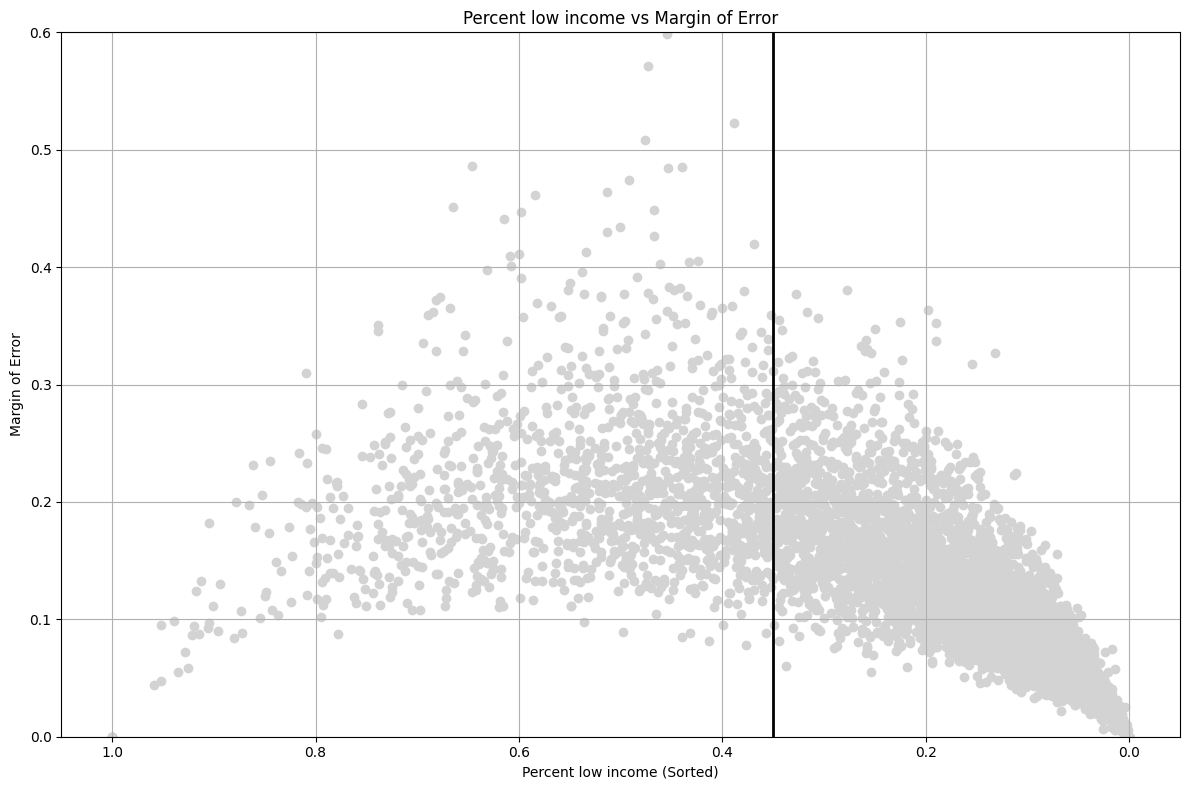

In [5]:
# plot low-income percent on the x-axis (least to greatest) and MOE on the y axis
import pandas as pd
import matplotlib.pyplot as plt

#Define input file path
input_file = 'percent_low_income_modified_GEOID.csv'
input_csv_file = f'{ipath}/{input_file}'

# Step 1: Load the CSV data
data = pd.read_csv(input_csv_file)

# Step 2: Sort by Inverse Percent from least to greatest
data_sorted = data.sort_values(by='Percent low income')

# Step 3: Plotting
plt.figure(figsize=(12, 8))
plt.scatter(data_sorted['Percent low income'], data_sorted['Margin of Error'], marker='o', linestyle='-', color='lightgray')
plt.xlabel('Percent low income (Sorted)')
plt.ylabel('Margin of Error')
plt.title('Percent low income vs Margin of Error')
plt.grid(True)

# Flip the x-axis
plt.gca().invert_xaxis()
# Set max value y-axis
plt.ylim(0, 0.6)

#mark 35% threshhold
plt.axvline(x=0.35, color='black', linewidth=2)
plt.tight_layout()

# Show the plot
plt.show()

# Visualization: Scatterplot with Designation by Color

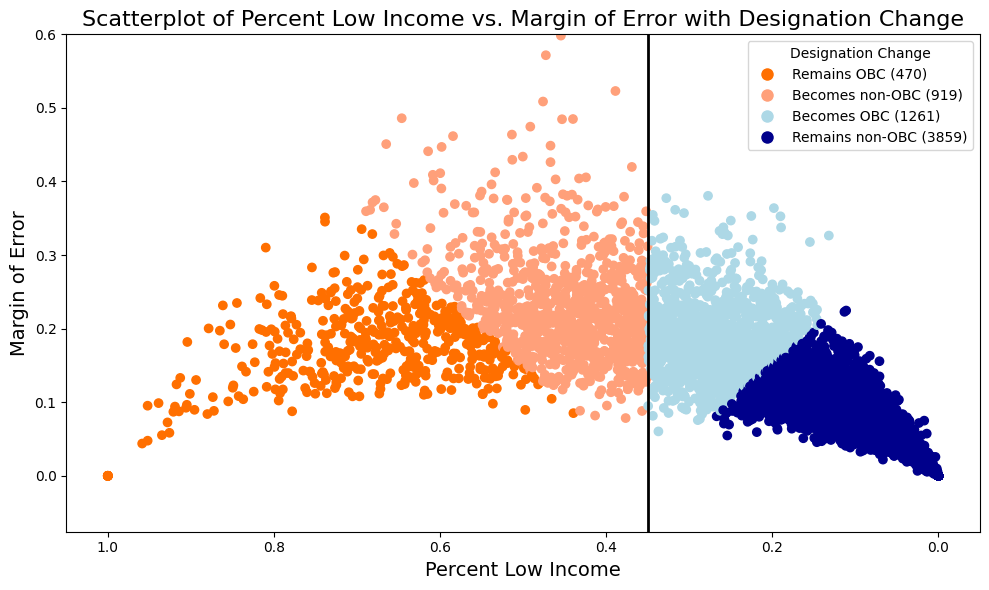

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Load the data
input_file = 'numerical_designation_percent_low_income_MG.csv'
file_path = f'{ipath}/{input_file}'
data = pd.read_csv(file_path)

# Sort the data
data_sorted = data.sort_values(by=['Percent low income', 'Margin of Error'], ascending=[False, True])

# Calculate counts for each Designation Change
designation_counts = data_sorted['Designation Change'].value_counts()

# Define color mapping based on Designation Change with hexadecimal color codes
color_mapping = {
    1: '#00008B',  # Dark blue
    2: '#FF6F00',  # Darker orange
    3: '#ADD8E6',  # Light blue
    4: '#FFA07A'   # Light orange
}

# Apply color mapping with a fallback color for any unmapped values
colors = data_sorted['Designation Change'].map(color_mapping).fillna('#808080')  # Gray for any unmapped values

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data_sorted['Percent low income'], data_sorted['Margin of Error'], c=colors)

# Set labels and title with increased font sizes
plt.xlabel('Percent Low Income', fontsize=14)
plt.ylabel('Margin of Error', fontsize=14)
plt.title('Scatterplot of Percent Low Income vs. Margin of Error with Designation Change', fontsize=16)

# Flip the x-axis
plt.gca().invert_xaxis()

# Set the maximum value of the y-axis to 0.8
plt.ylim(top=0.6)

# Create custom legend handles with counts
legend_handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[2], markersize=10, label=f'Remains OBC ({designation_counts.get(2, 0)})'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[4], markersize=10, label=f'Becomes non-OBC ({designation_counts.get(4, 0)})'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[3], markersize=10, label=f'Becomes OBC ({designation_counts.get(3, 0)})'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[1], markersize=10, label=f'Remains non-OBC ({designation_counts.get(1, 0)})')
]

# Add legend to the plot
plt.legend(title='Designation Change', handles=legend_handles)

#mark 35% threshhold
plt.axvline(x=0.35, color='black', linewidth=2)
plt.tight_layout()

# Show plot
plt.show()


# Visualization: Mapping

Before mapping, calculate the lower bound and upper bound of the confidence interval:

In [70]:
#Script to calculate lower and upper bounds 
import pandas as pd

# Define input and output file paths
input_file_name = 'percent_low_income_modified_GEOID.csv'
input_file_path = f'{ipath}/{input_file}'
output_file_name = 'bounds_percent_low_income_MG.csv'
output_file = f'{opath}/{output_file_name}'
# Load the CSV file
data = pd.read_csv(input_file_path)

# Columns assumed to be labeled "Inverse Percent" and "Margin of Error"
estimate_column = "Percent low income"
moe_column = "Margin of Error"

# Calculate the lower bound of the confidence interval
data['Lower bound'] = data[estimate_column] - data[moe_column]

# Calculate the upper bound of the confidence interval
data['Upper bound'] = data[estimate_column] + data[moe_column]

# Write the modified DataFrame to a new CSV file
data.to_csv(output_file, index=False)

print(f"Results have been written to {output_file}")

Results have been written to /Users/ayla/workflow/data/bounds_percent_low_income_MG.csv


Check for NaN values in bounds_percent_low_income_MG.csv

In [72]:
#Check for NaN again
file_name = 'bounds_percent_low_income_MG.csv'
file_path = f"{ipath}/{file_name}"  
check_nan_in_csv(file_path)

No NaN values found in the CSV file.


For visualization purposes, the BGs will be divided into 4 categories based on their estimate and MOE: 
1. Non-OBC, remains non-OBC when MOE considered
2. OBC, remains OBC when MOE considered 
3. Non-OBC, becomes OBC when MOE is added to estimate (upper bound)
4. OBC, becomes non-OBC when MOE  is subtracted from estimate (lower bound)

This script takes the bounds_percent_low_income_MG.csv file and creates a new file called numerical_designation_percent_low_income_MG.csv with a new columun called "Designation Change"

In [4]:
#Create designation change column for each of the four categories for ease of mapping
import pandas as pd
import os

# Define input and output file paths
input_file_name = 'bounds_percent_low_income_MG.csv'
input_csv = f"{ipath}/{input_file_name}" 
output_file_name = 'numerical_designation_percent_low_income_MG.csv'
output_csv = f"{opath}/{output_file_name}" 

# Function to determine the designation change
def determine_designation_change(row):
    estimate = row['Percent low income']
    upper_bound = row['Upper bound']
    lower_bound = row['Lower bound']
    
    if estimate < 0.35 and upper_bound < 0.35:
        return 1
    elif estimate > 0.35 and lower_bound > 0.35:
        return 2
    elif estimate < 0.35 and upper_bound > 0.35:
        return 3
    elif estimate > 0.35 and lower_bound < 0.35:
        return 4
    else:
        return None  # in case the row does not meet any condition, though logically this shouldn't happen

#Read the input file
data = pd.read_csv(input_csv)

# Apply the function to each row to create the new column
data['Designation Change'] = data.apply(determine_designation_change, axis=1)

# Count the number of rows assigned to each designation category
counts = data['Designation Change'].value_counts().sort_index()

# Print the counts
print("Number of rows sorted into each designation category:")
for designation, count in counts.items():
    print(f"Designation {designation}: {count} rows")

# Print rows that were not assigned any designation
not_assigned = data[data['Designation Change'].isnull()]
print("\nRows not assigned any designation:")
print(not_assigned)

# Write the output to a new CSV file
data.to_csv(output_csv, index=False)

print(f"Output written to {output_csv}")

Number of rows sorted into each designation category:
Designation 1: 3859 rows
Designation 2: 470 rows
Designation 3: 1261 rows
Designation 4: 919 rows

Rows not assigned any designation:
Empty DataFrame
Columns: [GEOID, Percent low income, Margin of Error, Lower bound, Upper bound, Designation Change]
Index: []
Output written to /Users/ayla/workflow/data/numerical_designation_percent_low_income_MG.csv


Check that 2 BGs from earlier (with some zero values in the total pop variance replicate ests) were correctly designated as "2," "OBC, remains OBC"

In [45]:
import pandas as pd
input_file_name = 'numerical_designation_percent_low_income_MG.csv'
input_csv = f'{ipath}/{input_file_name}'
df = pd.read_csv(input_csv)

# Specify the value to search for in the GEOID column
geoid_value = 340155020026 
geoid_value_2 = 340155024001
# Filter the DataFrame to get rows where the GEOID column is equal to the specified value
filtered_df = df[df['GEOID'] == geoid_value]
filtered_df_2 = df[df['GEOID'] == geoid_value_2]
# Print the filtered rows
print(filtered_df)
print(filtered_df_2)

             GEOID  Percent low income  Margin of Error  Lower bound  \
2702  340155020026                 1.0              0.0          1.0   

      Upper bound  Designation Change  
2702          1.0                   2  
             GEOID  Percent low income  Margin of Error  Lower bound  \
2715  340155024001                 1.0              0.0          1.0   

      Upper bound  Designation Change  
2715          1.0                   2  


Create a choropleth map based off "Designation Change" column. Before running the script below, the correct TIGERline shapefile must be downloaded and added to the project data folder. The TIGERLine shapefile is the 2022 NJ Block Group shapefile and can be found at this link: https://catalog.data.gov/dataset/tiger-line-shapefile-2022-state-new-jersey-nj-block-group

(NOTE: download the zip folder and place the *ENTIRE* zip folder in the data folder then unzip it. Python needs access to the entire zip folder, not just the .shp file)

The output of this script is a map that will appear in the jupyter notebook, as well as 5 files (like the files in the TIGERLine zip) that will allow you to open the map in a GIS program. These files will appear seperately the project data folder. You will have to create a new folder to consolidate them and then compress it to create a zip folder that can be opened in GIS.  

First 5 rows of the CSV file:
          GEOID  Percent low income  Margin of Error  Lower bound  \
0  340010001001            0.689938         0.178294     0.511645   
1  340010001002            0.585114         0.157678     0.427437   
2  340010002001            0.460027         0.253106     0.206921   
3  340010002002            0.379562         0.231805     0.147757   
4  340010002003            0.217391         0.190308     0.027083   

   Upper bound  Designation Change  
0     0.868232                   2  
1     0.742792                   2  
2     0.713133                   4  
3     0.611367                   4  
4     0.407700                   3  

First 5 rows of the shapefile:
  STATEFP COUNTYFP TRACTCE BLKGRPCE         GEOID       NAMELSAD  MTFCC  \
0      34      023  001806        6  340230018066  Block Group 6  G5030   
1      34      023  009101        1  340230091011  Block Group 1  G5030   
2      34      023  001806        2  340230018062  Block Group 2  G5030   
3

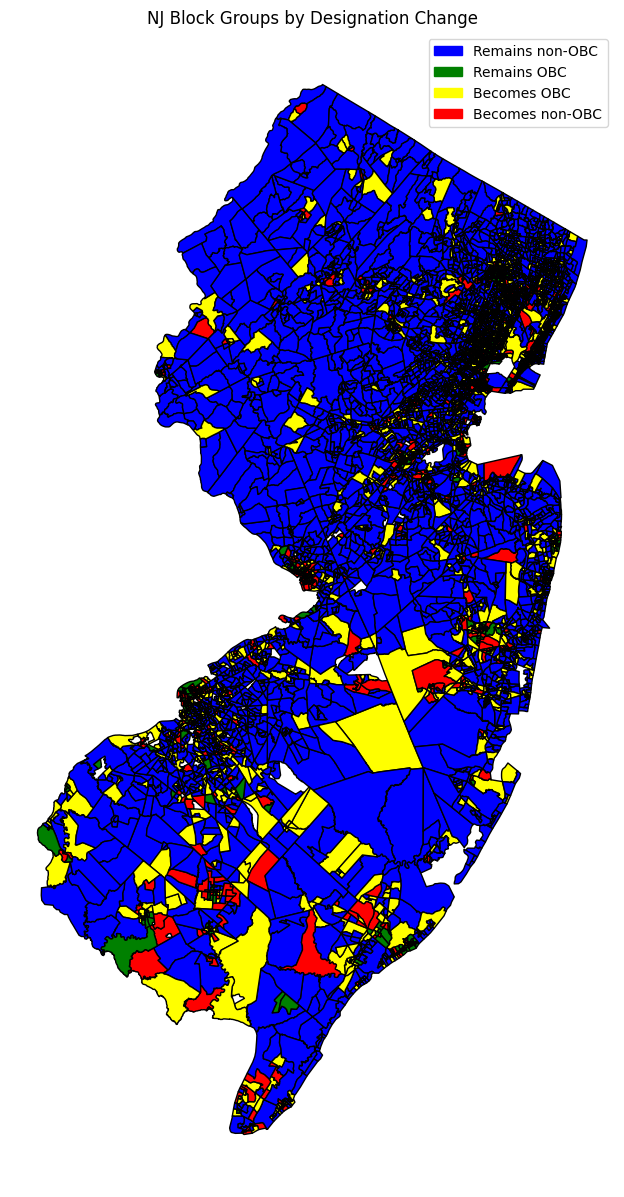

/var/folders/05/b938g1y5699g5v98z_76f_g00000gn/T/ipykernel_89264/2543702862.py:62: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_shapefile)
/Users/ayla/workflow/.venv/lib/python3.9/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'Percent low income' to 'Percent lo'
  ogr_write(
/Users/ayla/workflow/.venv/lib/python3.9/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'Margin of Error' to 'Margin of'
  ogr_write(
/Users/ayla/workflow/.venv/lib/python3.9/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'Lower bound' to 'Lower boun'
  ogr_write(
/Users/ayla/workflow/.venv/lib/python3.9/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'Upper bound' to 'Upper boun'
  ogr_write(
/Users/ayla/workflow/.venv/lib/python3.9/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laund

Shapefile saved to /Users/ayla/workflow/data/low_income_OBC_designation.shp


In [3]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Read the input CSV file
input_file_name = 'numerical_designation_percent_low_income_MG.csv'
input_csv = f'{ipath}/{input_file_name}'
data = pd.read_csv(input_csv)

# Print the first 5 rows of the CSV file
print("First 5 rows of the CSV file:")
print(data.head())

# Read the shapefile
shapefile_name = 'tl_2022_34_bg'
shapefile_path = f'{ipath}/{shapefile_name}'
gdf = gpd.read_file(shapefile_path)

# Print the first 5 rows of the shapefile
print("\nFirst 5 rows of the shapefile:")
print(gdf.head())

#Convert to strings
gdf['GEOID'] = gdf['GEOID'].astype(str)
data['GEOID'] = data['GEOID'].astype(str)

# Merge the data based on a common column, assuming 'GEOID' is the common column in both files
# Adjust 'GEOID' to match the actual common column name
gdf = gdf.merge(data, on='GEOID')

# Create a color map based on the Designation Change values
color_map = {1: 'blue', 2: 'green', 3: 'yellow', 4: 'red'}

# Add a column to the GeoDataFrame for colors
gdf['color'] = gdf['Designation Change'].map(color_map)

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
gdf.plot(ax=ax, color=gdf['color'], edgecolor='black')

# Add a legend
import matplotlib.patches as mpatches
legend_labels = {
    1: 'Remains non-OBC',
    2: 'Remains OBC',
    3: 'Becomes OBC',
    4: 'Becomes non-OBC'
}
legend_patches = [mpatches.Patch(color=color, label=legend_labels[key]) for key, color in color_map.items()]
plt.legend(handles=legend_patches, loc='upper right')

# Add title and axis off
plt.title('NJ Block Groups by Designation Change')
ax.axis('off')

# Save the plota
plt.savefig('nj_block_groups_designation_map.png', dpi=300)
plt.show()

# Save the GeoDataFrame as a shapefile
output_shapefile = f'{ipath}/low_income_OBC_designation.shp'
gdf.to_file(output_shapefile)

print(f"Shapefile saved to {output_shapefile}")

Create new shapefile with only block groups that change designation ('Becomes OBC' and 'Becomes non-OBC') to perform Moran's I in ArcGIS Pro

In [7]:
import geopandas as gpd

# Load the shapefile
shapefile_path = '/Users/ayla/workflow/data/low_income_obc_mapping_folder'
gdf = gpd.read_file(shapefile_path)

# Filter the GeoDataFrame to include only records with 'designation_change' equal to 3 or 4
filtered_gdf = gdf[gdf['Designatio'].isin([3, 4])]

# Save the filtered GeoDataFrame to a new shapefile
filtered_shapefile_path = '/Users/ayla/workflow/data/OBC_designation_changes.shp'
filtered_gdf.to_file(filtered_shapefile_path)

print(f"Filtered shapefile saved to: {filtered_shapefile_path}")

Filtered shapefile saved to: /Users/ayla/workflow/data/OBC_designation_changes.shp


# Visualization: Histograms
Create histograms for BG designation counts (using 'numerical_designation_percent_low_income_MG.csv')

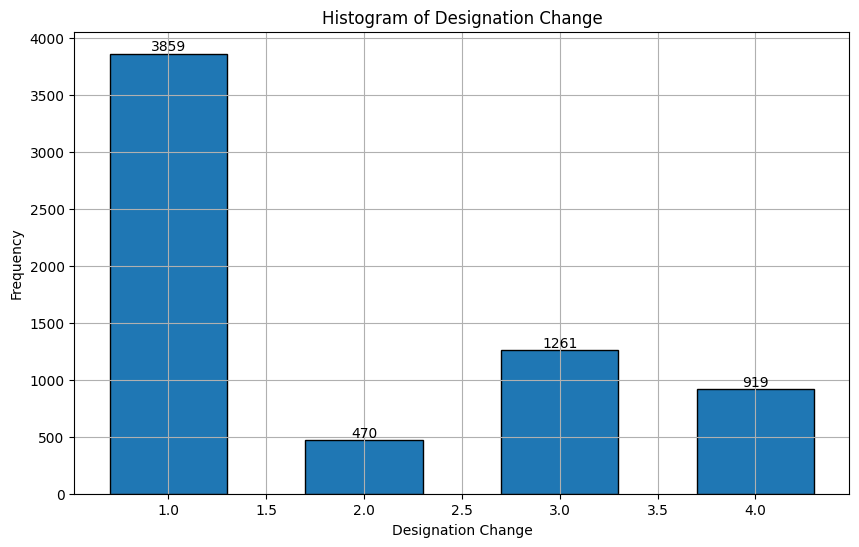

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Load the CSV file
# Read the input CSV file
input_file_name = 'numerical_designation_percent_low_income_MG.csv'
input_csv = f'{ipath}/{input_file_name}'
df = pd.read_csv(input_csv)

# Create a histogram for the "Designation Change" column
plt.figure(figsize=(10, 6))
designation_change_values = df['Designation Change'].dropna()
bins = np.arange(designation_change_values.min(), designation_change_values.max() + 1.5) - 0.5

hist, bin_edges = np.histogram(designation_change_values, bins=bins)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Plot the histogram
plt.bar(bin_centers, hist, width=0.6, edgecolor='black')

# Label the bins if desired
for center, count in zip(bin_centers, hist):
    plt.text(center, count, str(count), ha='center', va='bottom')

plt.title('Histogram of Designation Change')
plt.xlabel('Designation Change')
plt.ylabel('Frequency')
plt.grid(True)

# Show the histogram
plt.show()

# Data Analysis: Stats

This code counts how many BGs are designated as OBCs and non-OBCs based on the published estimates (not considering MOE)

In [20]:
import pandas as pd

# Read the CSV file into a DataFrame
file_name = "percent_low_income_confidence_intervals.csv"
csv_file_path = f"{ipath}/{file_name}"
df = pd.read_csv(csv_file_path)

# Check the number of rows where the "Estimate" column is greater than or equal to 0.35
count_gte_035 = df[df['Percent low income'] >= 0.35].shape[0]

# Check the number of rows where the "Estimate" column is less than 0.35
count_lt_035 = df[df['Percent low income'] < 0.35].shape[0]

# Print the results
print(f"OBC block groups: {count_gte_035}")
print(f"Non-OBC block groups: {count_lt_035}")

OBC block groups: 1389
Non-OBC block groups: 5120
